In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import torchvision.datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
from torchvision.transforms import v2

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
###
# Genre and Mood are categorical variables.
# Genre:
# 0 - Jazz
# 1 - Jazz with Vocals
# 2 - Classical
# 3 - Pop
# 4 - Rock
# 5 - World
# 6 - Electronica
# 7 - Other
#
# Mood:
# 0 - Mellow
# 1 - Not Mellow
###

class SongImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.song_frame = pd.read_csv(csv_file, dtype={'image':str, 'genre':np.int64, 'mood':np.int64})
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.song_frame)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        img_file = self.song_frame.iloc[index, 0]
        img_path = os.path.join(self.root_dir, img_file)

        # if os.path.isfile(img_path):
        #     print(img_path)
        # else:
        #     print("File not found")
        #     exit(1)

        image = plt.imread(img_path)
        genre = self.song_frame.iloc[index, 1]
        mood = self.song_frame.iloc[index, 2]

        return self.transform(image), mood, genre

In [4]:
# add transforms and instantiate the dataset
transform = v2.Compose([
    # v2.Resize(size=(300, 1200), antialias=True),
    # v2.ToDtype(torch.float32, scale=True),
    v2.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

img_dataset = SongImageDataset(csv_file='/content/drive/MyDrive/MIT_DL_Project_Data/melspec/music_melspec_data.csv',
                           root_dir='/content/drive/MyDrive/MIT_DL_Project_Data/melspec',
                           transform=transform)
# print(len(dataset))
# print(dataset[0]['image'].shape)
# print(dataset[0]['filename'])
# print(dataset[0]['genre'])
# print(dataset[0]['mood'])
# print(dataset[0]['image'].dtype)
# plt.imshow(dataset[0]['image'])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [10]:
# dataset split
img_train, img_val = torch.utils.data.random_split(img_dataset, [int(len(img_dataset)*0.8), int(len(img_dataset)*0.2)])
print('train: ', len(img_train))

img_val, img_test = torch.utils.data.random_split(img_val, [int(len(img_val)*0.5), int(len(img_val)*0.5)])
print('validation: ', len(img_val))
print('test: ', len(img_test))

# dataloaders
batch_size = 32
dataloaders = {'train': DataLoader(img_train, batch_size=batch_size),
               'val': DataLoader(img_val, batch_size=batch_size),
               'test': DataLoader(img_test, batch_size=batch_size)}

dataset_sizes = {'train': len(img_train),
                 'val': len(img_val),
                 'test': len(img_test)}
print(f'dataset_sizes = {dataset_sizes}')

train:  328
validation:  41
test:  41
dataset_sizes = {'train': 328, 'val': 41, 'test': 41}


The image classifier class. Since the images are 1600x400 pixel size and contain a lot of detail, I added higher number of outchannels as the images were scaled down to a manageable size for linearizing. As the dataset was very small (410 elements), I chose to use a batch size of 16 (besides my validation and tesing size was just 41), so that it introduced a little bit of noise in the gradient estimation and thereby providing regularization.

In [6]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes = 2, dropout = 0.25):
        super(CNNClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout)

        # Convolutional layers
        self.conv0 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        # Max-pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flattening layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 100 * 25, 512) # outchannels * (reduced_img_width * reduced_img_height)
        self.fc2 = nn.Linear(512, num_classes)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        ####
        # 4 Convolution and 4 MaxPool layers with 2 fully connected layers.
        # We need to reduce the image size from 1600x400 100x25.
        ####
        x = self.relu(self.conv0(x))
        x = self.pool(x)

        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.pool(x)

        # flatten the tensor 'x'
        # x = x.view(-1, 256 * 100 * 25)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)

        # Final layer with softmax activation function.
        x = self.fc2(x)

        return x

The training function is almost the same as the ones we have used in the past assignments, except that I added randomizing of the dataset split at any epoch iteration via a (epoch % randomize_epoch) param. It is a technique to introduce randomness into the training process and prevent overfitting. If the the dataset split was randomized every 10 epochs, the training curves for loss and accuracy looked very haphazard but eventually converged, whereas if the dataset was randomized every epoch, the curves looked less haphazard, but choppy and converged as well.

The other small change made to the code was to add other_labels to the Tuple returned from the dataloaders when iterating over them. This was done, to see if I could train the CNN using the other_labels, which in this case is music Genre.


In [7]:
# training function
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25,  randomize_epoch = 5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        if epoch % randomize_epoch == 0:
            print('Randomize the dataset')
            img_train, img_val = torch.utils.data.random_split(img_dataset, [int(len(img_dataset)*0.8), int(len(img_dataset)*0.2)])
            img_val, img_test = torch.utils.data.random_split(img_val, [int(len(img_val)*0.5), int(len(img_val)*0.5)])

            # We will create DataLoaders just like before with a batch size of 100
            dataloaders = {'train': DataLoader(img_train, batch_size=batch_size),
                        'val': DataLoader(img_val, batch_size=batch_size),
                        'test': DataLoader(img_test, batch_size=batch_size)}

            dataset_sizes = {'train': len(img_train),
                            'val': len(img_val),
                            'test': len(img_test)}

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, other_labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (bas
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

The classification and plotting functions are pretty much the same as before with some minor changes to add other_labels to the Tuple and getting the class_labels from the labels tensor directly, instead of using a hardcoded class labels.

In [8]:
# classification function
def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels, other_labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs), dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def plot_cm(model, device, dataloaders, phase='test'):
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    class_labels = labels.unique().tolist()
    print('class_labels: ', class_labels)
    print('preds: ', preds)
    print('labels: ', labels)
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

CNNClassifier(
  (dropout): Dropout(p=0.5, inplace=False)
  (conv0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc0): Linear(in_features=6912, out_features=32,

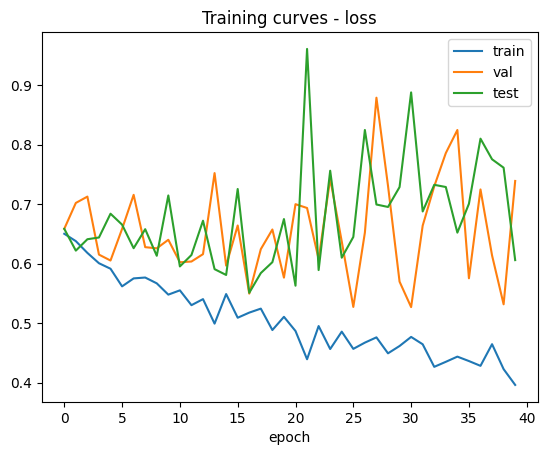

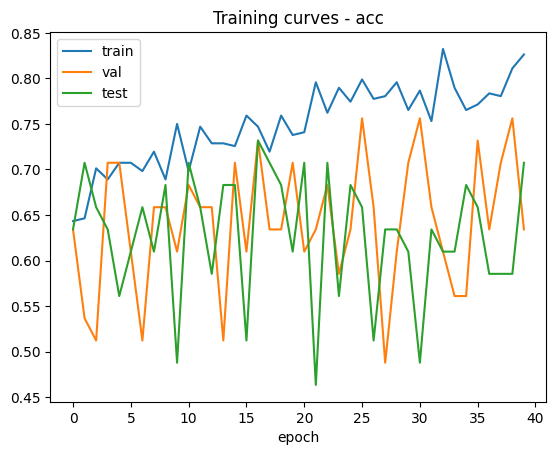

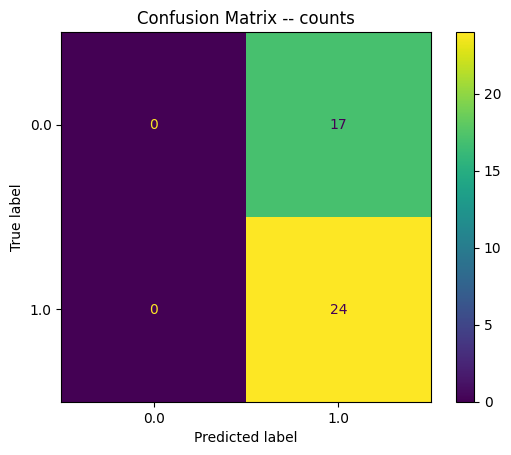

In [11]:
learning_rate = 0.0001
num_epochs = 40
randomize_epoch = 1

model = CNNClassifier(dropout = 0.5).to(device)
print(model)

# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
model, training_curves = train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer,
                                                    scheduler, num_epochs=num_epochs,  randomize_epoch=randomize_epoch)

plot_training_curves(training_curves, phases=['train', 'val', 'test'])
res = plot_cm(model, device, dataloaders, phase='test')
plt.show()
